# Explorative Analysis of the Younger Dataset

In [21]:
import os
import pathlib
import networkx as nx
from tqdm import tqdm
import pickle as pkl

import matplotlib.pyplot as plt

from youngernns.data.network import Network

from collections import Counter

## Global Variables

In [22]:
DATA_PATH = os.path.join("..","data","filter_series_with_attributes_paper")
OUTPUT_DIR = os.path.join("..", "output")

## Loading Data

In [5]:
def get_graph_paths():
    # find all paths for network folders DATA_PATH/gaphd_id/network/
    graph_folders = []
    for root, dirs, files in os.walk(DATA_PATH):
        if 'network' in dirs:
            graph_folders.append(os.path.join(root, 'network'))
    return graph_folders

In [6]:
graph_paths = get_graph_paths()
print(f"Found {len(graph_paths)} graphs")
print(f"Example of first graph path: {graph_paths[0]}")

Found 7629 graphs
Example of first graph path: ../data/filter_series_with_attributes_paper/0ad2b9b313487b294428174cf56d7d22/network


Let's look at the first graph

In [7]:
NN = Network()
NN.load(pathlib.Path(graph_paths[0]))

In [8]:
NN.graph.nodes(data=True)["0"]

{'operator': {'op_type': 'Transpose', 'domain': ''},
 'attributes': {'perm': {'value': [0, 3, 1, 2],
   'doc_string': '',
   'attr_type': 7}},
 'features': {'operator': {'op_type': 'Transpose', 'domain': ''},
  'attributes': {'perm': (7, '[0, 3, 1, 2]')}}}

Let's look at the graph operators

In [9]:
def get_graph_operator_types(graph):
    for att in nx.get_node_attributes(graph, "operator").values():
        yield att['op_type'] 

In [24]:
operators_pickle_path = os.path.join(OUTPUT_DIR, "operator_types.pkl")

if not os.path.exists(operators_pickle_path):
    operator_types = []

    for graph_path in tqdm(graph_paths):
        NN = Network()
        NN.load(pathlib.Path(graph_path))
        operator_types.extend(get_graph_operator_types(NN.graph))

    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    with open(operators_pickle_path, "wb") as f:
        pkl.dump(operator_types, f)
    
    print(f"Saved {len(operator_types)} operator types")
    print(f"Saved to {operators_pickle_path}")
else:
    with open(operators_pickle_path, "rb") as f:
        operator_types = pkl.load(f)
        print(f"Loaded {len(operator_types)} operator types")

Loaded 12396579 operator types


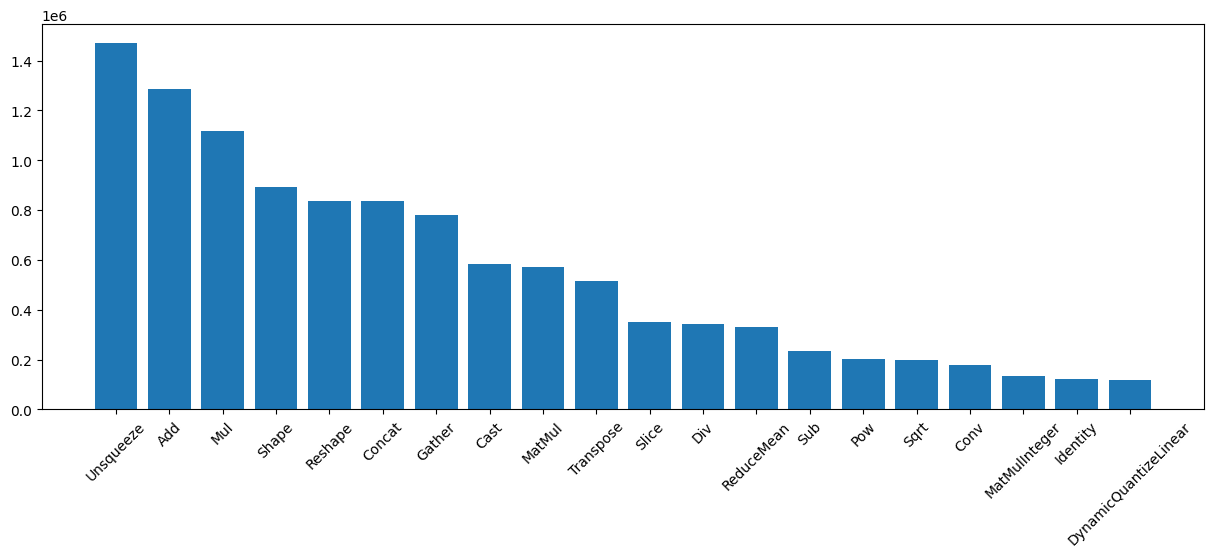

In [25]:
# plot histogram of top X operator types
operator_types_counter = Counter(operator_types)
top_x = 20
top_x_operator_types = operator_types_counter.most_common(top_x)

plt.figure(figsize=(15,5))
plt.bar([x[0] for x in top_x_operator_types], [x[1] for x in top_x_operator_types])
plt.xticks(rotation=45)
plt.show()